# Model Fitting and Forecasting using Linear Regression Techniques to incorporate sentiment scores

In [54]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sb  
sb.set_style('darkgrid')
from scipy import stats
from statsmodels.graphics.api import qqplot
from sklearn.metrics import r2_score
#from sklearn import model_selection
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
sb.set_palette('muted')

## Methodology

### 1. Create a matrix of lagged predictors (exchange rate as well as sentiment scores)
### 2. Split into test and train sets
### 3. Use lasso regression to fit a model to the training data
### 4. Evaluate the coefficients of the model
### 5. Predict on the test data

## Read in the Data

In [55]:
daily_data = pd.read_csv('../exchangeratedata/daily_full.csv', skiprows=7, header=0)
monthly_data = pd.read_csv('../exchangeratedata/monthly_rates.csv', skiprows=11, header=0)

In [56]:
daily_data['datetime'] = pd.to_datetime(daily_data['DATE'])
daily_data['dayofweek'] = daily_data['datetime'].apply(lambda row: row.dayofweek)
weekly_data = daily_data[daily_data['dayofweek'] == 4]

In [57]:
print weekly_data.head(5)

           DATE  IUDBEDR  IUDSOIA  XUDLDS1  XUDLERS  XUDLUSS   datetime  \
3   07 Jan 2000     5.50   4.4172   1.6374   1.5909   1.6372 2000-01-07   
8   14 Jan 2000     5.75   5.0126   1.6351   1.6152   1.6349 2000-01-14   
13  21 Jan 2000     5.75   5.8912   1.6506   1.6391   1.6506 2000-01-21   
18  28 Jan 2000     5.75   6.0424   1.6198   1.6529   1.6198 2000-01-28   
23  04 Feb 2000     5.75   5.6334   1.5885   1.6214   1.5886 2000-02-04   

    dayofweek  
3           4  
8           4  
13          4  
18          4  
23          4  


In [58]:
UK_US = pd.DataFrame()
UK_US['UK_US']=weekly_data['XUDLUSS']
UK_US['LIBOR']=weekly_data['IUDSOIA']
UK_US = UK_US.set_index(weekly_data['datetime'].values) # index has to be the variable depicting date-time information

UK_EU = pd.DataFrame()
UK_EU['UK_EU']=weekly_data['XUDLERS']
UK_EU['LIBOR']=weekly_data['IUDSOIA']
UK_EU.set_index(weekly_data['datetime'].values)

# dates = pd.DatetimeIndex(UK_US.index)
# dates[:'2000-03-10']
ts = UK_US['UK_US']
libor = UK_US['LIBOR']

Plot of the UK/US exchange rate:

# Generate Predictor matrix of lags for testing regression models

In [59]:
# start with an n x 20 matrix (i.e. for each time point, the columns are the lags at t=t-1, t=t-2 etc)
n_lags = 20
time_series_lags = np.zeros((len(ts), n_lags))

for n in range(1, n_lags+1):
    shifted = ts.shift(n)
    for index, val in enumerate(ts.values):
        if index > n_lags-1:
            time_series_lags[index, n-1] = shifted[index]

In [60]:
# start with an n x 20 matrix (i.e. for each time point, the columns are the lags at t=t-1, t=t-2 etc)
n_lags = 20
libor_series_lags = np.zeros((len(libor), n_lags))

for n in range(1, n_lags+1):
    shifted = libor.shift(n)
    for t, val in enumerate(libor.values):
        if t > n_lags-1:
            libor_series_lags[t, n-1] = shifted[t]

In [61]:
#np.savetxt("test.csv", time_series_lags, delimiter=",")

# Sentiment Scores

The sentiment scores for the news articles from each week were generated in a separate notebook and saved to a csv. 

In [62]:
sentiment_scores = pd.read_csv('../data_collection/scores_df.csv', delimiter=',')
sentiment_scores = sentiment_scores.set_index(pd.DatetimeIndex(sentiment_scores['weeks']))
sentiment_scores.drop('weeks', axis=1, inplace=True)

In [63]:
print sentiment_scores.index.unique()
print ts.index.unique()

DatetimeIndex(['2000-01-03', '2000-01-10', '2000-01-17', '2000-01-24',
               '2000-01-31', '2000-02-07', '2000-02-14', '2000-02-21',
               '2000-02-28', '2000-03-06',
               ...
               '2016-08-22', '2016-08-29', '2016-09-05', '2016-09-12',
               '2016-09-19', '2016-09-26', '2016-10-03', '2016-10-10',
               '2016-10-17', '2016-10-24'],
              dtype='datetime64[ns]', length=878, freq=None)
DatetimeIndex(['2000-01-07', '2000-01-14', '2000-01-21', '2000-01-28',
               '2000-02-04', '2000-02-11', '2000-02-18', '2000-02-25',
               '2000-03-03', '2000-03-10',
               ...
               '2016-08-19', '2016-08-26', '2016-09-02', '2016-09-09',
               '2016-09-16', '2016-09-23', '2016-09-30', '2016-10-07',
               '2016-10-14', '2016-10-21'],
              dtype='datetime64[ns]', length=852, freq=None)


In [64]:
new_index = sentiment_scores.apply(lambda row: row.index + datetime.timedelta(days=4))['avg_weekly_pos_score']

In [65]:
sentiment_scores = sentiment_scores.set_index(new_index)

## Filtering out weeks with no exchange rate data

The exchange rate data is extracted on a thursday and in some weeks if there was no trading on a thursday then the exchange rate data is not present for that week in our extracted time series so there are  fewer weeks in the exchange rate data than for articles. Need to make sure the weeks match in both sentiment scores and exchange rate time series. 

In [66]:
print sentiment_scores.index.unique()
print ts.index.unique()

DatetimeIndex(['2000-01-07', '2000-01-14', '2000-01-21', '2000-01-28',
               '2000-02-04', '2000-02-11', '2000-02-18', '2000-02-25',
               '2000-03-03', '2000-03-10',
               ...
               '2016-08-26', '2016-09-02', '2016-09-09', '2016-09-16',
               '2016-09-23', '2016-09-30', '2016-10-07', '2016-10-14',
               '2016-10-21', '2016-10-28'],
              dtype='datetime64[ns]', name=u'avg_weekly_pos_score', length=878, freq=None)
DatetimeIndex(['2000-01-07', '2000-01-14', '2000-01-21', '2000-01-28',
               '2000-02-04', '2000-02-11', '2000-02-18', '2000-02-25',
               '2000-03-03', '2000-03-10',
               ...
               '2016-08-19', '2016-08-26', '2016-09-02', '2016-09-09',
               '2016-09-16', '2016-09-23', '2016-09-30', '2016-10-07',
               '2016-10-14', '2016-10-21'],
              dtype='datetime64[ns]', length=852, freq=None)


In [67]:
ts_df = pd.DataFrame(data=ts)

In [68]:
ts_df.head()

,UK_US
2000-01-07,1.6372
2000-01-14,1.6349
2000-01-21,1.6506
2000-01-28,1.6198
2000-02-04,1.5886


In [69]:
time_series_filtered = ts_df.merge(sentiment_scores, right_index=True, left_index=True)

In [70]:
pos = time_series_filtered['avg_weekly_pos_score']
neg = time_series_filtered['avg_weekly_neg_score']
ts_filtered = time_series_filtered['UK_US']

## Examine the autocorrelation of sentiment scores

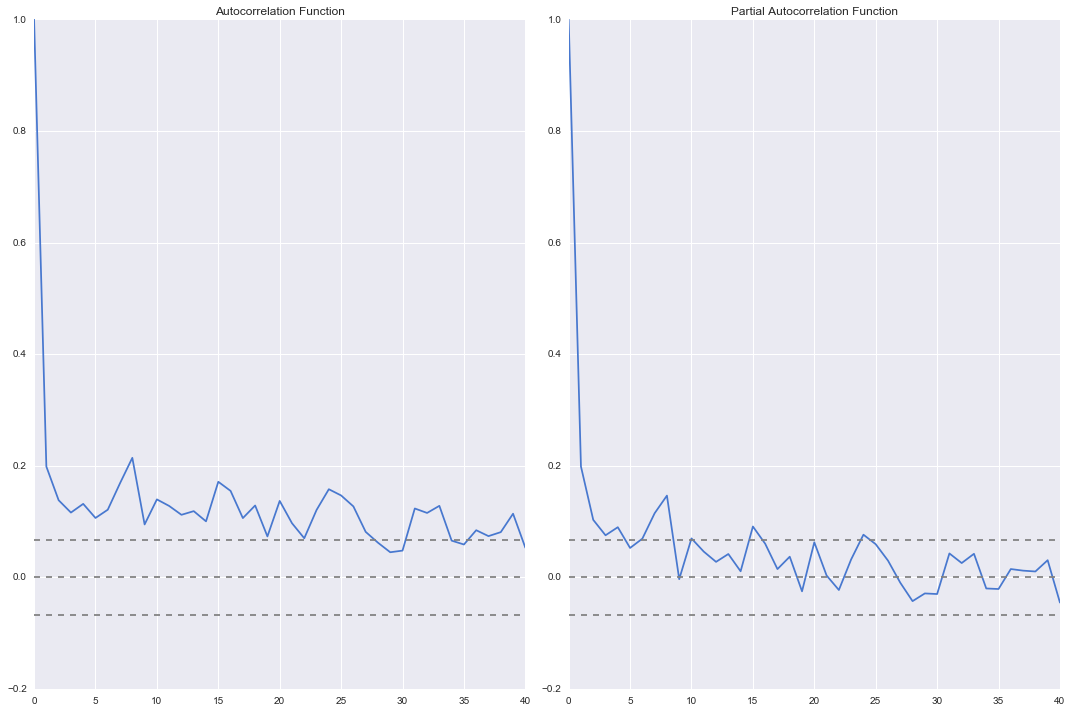

In [71]:
lag_acf = acf(pos, nlags=40)
lag_pacf = pacf(pos, nlags=40, method='ols')

#Plot ACF: 
plt.figure(figsize=(15,10))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pos)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pos)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pos)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pos)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## Create lagged values of the sentiment scores

In [72]:
n_lags = 20
pos_sentiment_lags = np.zeros((len(pos.values), n_lags))

for n in range(1, n_lags+1):
    shifted = pos.shift(n)
    for t, val in enumerate(pos.values):
        if t > n_lags-1:
            pos_sentiment_lags[t, n-1] = shifted[t]
            
n_lags = 20
neg_sentiment_lags = np.zeros((len(neg.values), n_lags))

for n in range(1, n_lags+1):
    shifted = neg.shift(n)
    for t, val in enumerate(neg.values):
        if t > n_lags-1:
            neg_sentiment_lags[t, n-1] = shifted[t]
            
n_lags = 20
time_series_filtered_lags = np.zeros((len(ts_filtered.values), n_lags))

for n in range(1, n_lags+1):
    shifted = ts_filtered.shift(n)
    for index, val in enumerate(ts_filtered.values):
        if index > n_lags-1:
            time_series_filtered_lags[index, n-1] = shifted[index]

# Lasso regularisation

In [73]:
def lasso_predict(predictor_arrays):
    predictors = np.concatenate(predictor_arrays, axis=1)
    predictor_matrix_df = pd.DataFrame(data=predictors, index=ts.index.values)
    predictor_matrix_df_trimmed = predictor_matrix_df[20:-20]
    predictor_matrix_df_subset_1 = predictor_matrix_df_trimmed['2000':'2006']
    predictor_matrix_df_subset_2 = predictor_matrix_df_trimmed['2007':'2016']
    
    # split into train and test sets 
    test_indices = predictor_matrix_df_subset_1.sample(frac=0.4).index
    train_indices = predictor_matrix_df_subset_1.drop(test_indices).index
    
    print 'Xtrain shape ', train_indices.shape
    print 'Xtest shape ', test_indices.shape
    
    # sort test index values to help with plotting 
    sorted_test_indices = test_indices.order()
    
    X_train = predictor_matrix_df_trimmed.ix[train_indices]
    X_test = predictor_matrix_df_trimmed.ix[sorted_test_indices]
    y_train = ts[train_indices].values
    y_test = ts[sorted_test_indices].values
    
    # fit ridge regression model
    lasso_cv = linear_model.LassoCV(normalize=True, cv=30, fit_intercept=True)
    lasso_cv.fit(X_train, y_train)
    
    # plot coefficients
    plt.figure(figsize=(15,10))
    plt.plot(lasso_cv.coef_)
#     plt.title('Lasso regression coefficients')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Lags', fontsize=20)
    plt.ylabel('Coefficient', fontsize=20)
    
    # validation set predictions
    test_predictions = lasso_cv.predict(X_test)
    
    # plot predictions
    
    plt.figure(figsize=(15,10))
    plt.scatter(sorted_test_indices, test_predictions, color='red', label='predictions')
    plt.scatter(sorted_test_indices, y_test, label='actual')
    plt.legend(loc='best', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Time (weeks)', fontsize=20)
    plt.ylabel('Exchange rate', fontsize=20)
    print 'score ', str(r2_score(y_test, test_predictions))
#     plt.title('Test predictions,  $R^2$ = ' + str(r2_score(y_test, test_predictions)))
    
    
    ## residual histogram
    plt.figure(figsize=(15,10))
    plt.hist((test_predictions-y_test), bins=100)
#     plt.title('Residuals')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Residual Error', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    
    return lasso_cv

## Univariate lasso regression model

Xtrain shape  (202,)
Xtest shape  (135,)
score  0.980003409864


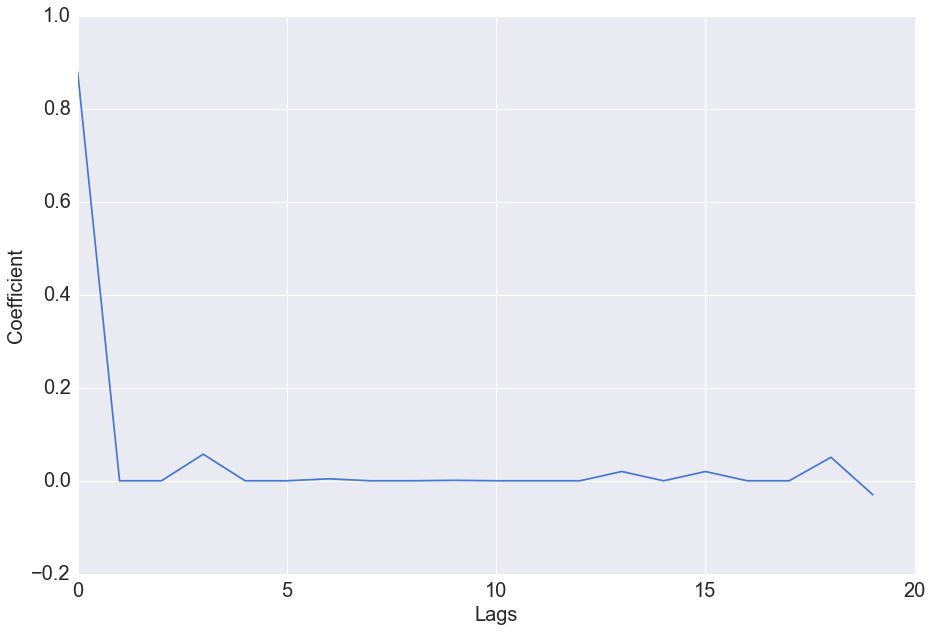

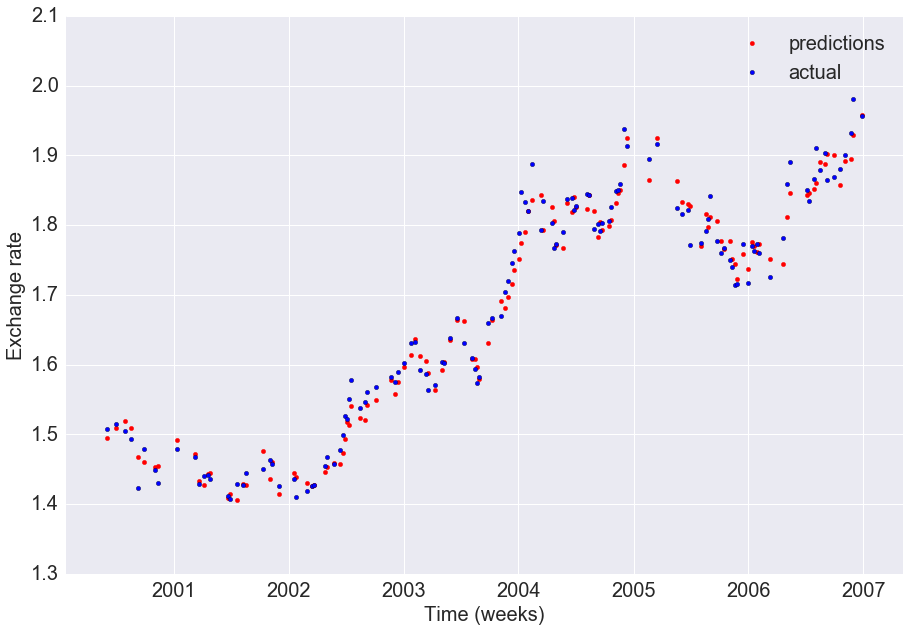

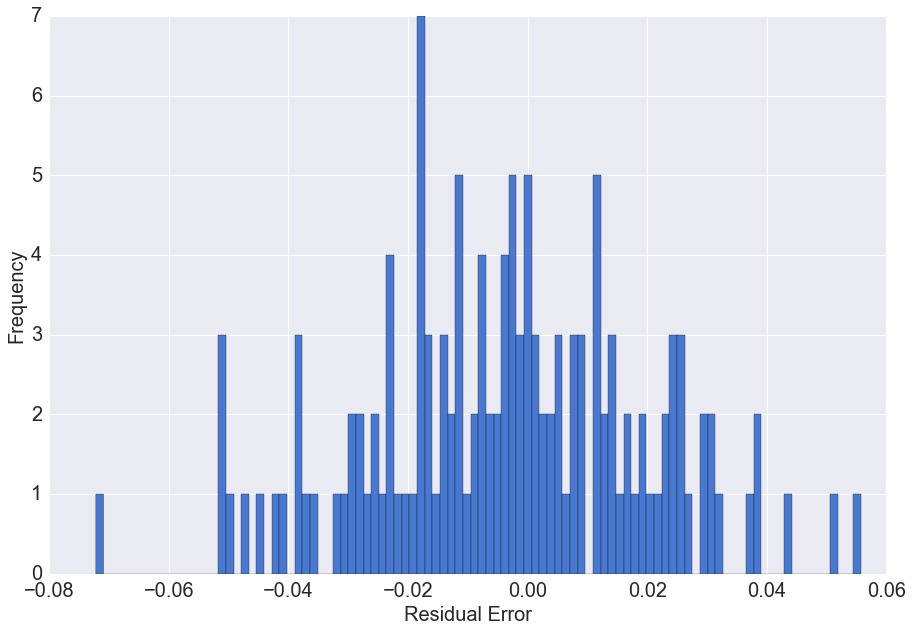

In [74]:
lasso_model = lasso_predict([time_series_filtered_lags])

The lasso regression coefficients show that most of the lags have very little predictive value apart from the first lag. 

## Multivariate regression with sentiment scores

Xtrain shape  (202,)
Xtest shape  (135,)
score  0.987015652389


LassoCV(alphas=None, copy_X=True, cv=30, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

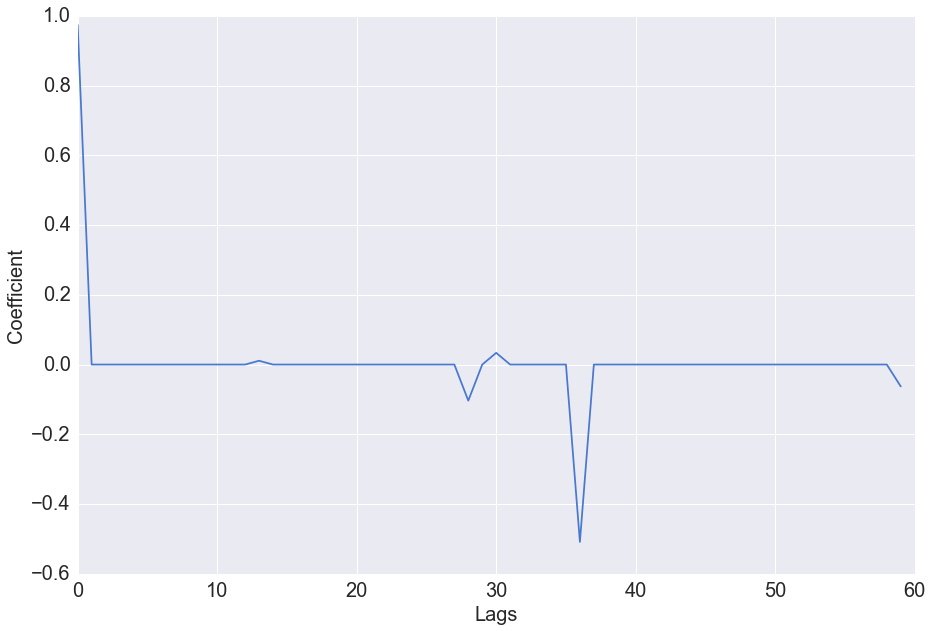

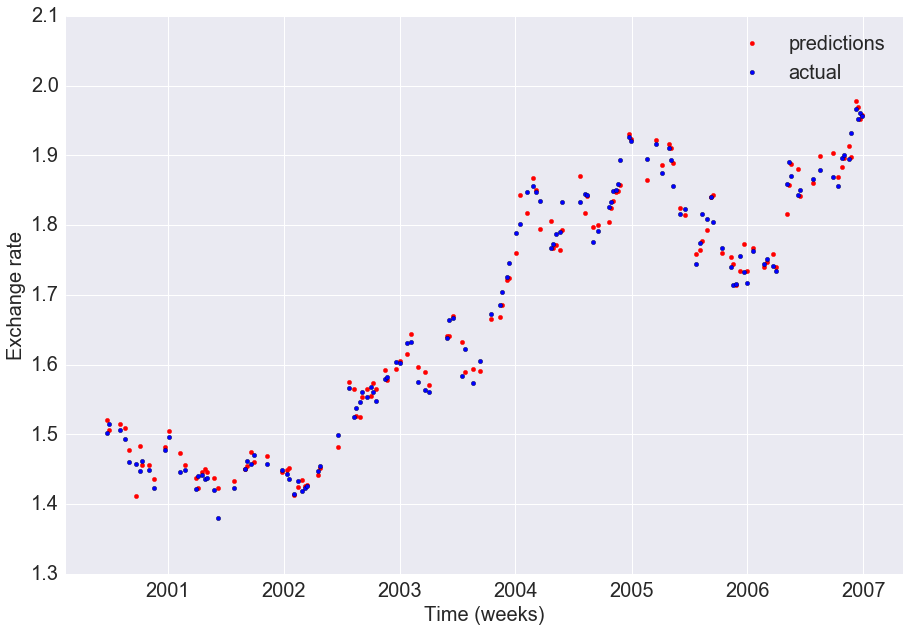

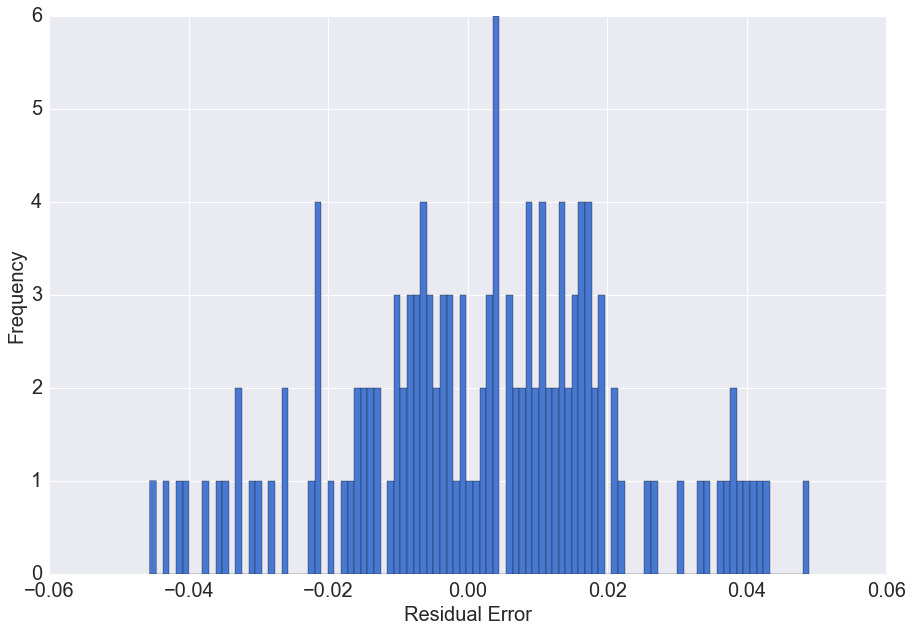

In [75]:
lasso_predict([time_series_filtered_lags, pos_sentiment_lags, neg_sentiment_lags])

Inclusion of the sentiment scores into the predictor matrix results in little improvement in the R2 score of the resulting model 

# Forecasting based on univariate regression model

Forecasts were generated incrementally:
  - lagged values for time t were used to predict the exchange rate for time t+1
  - this was used as the best estimate of the value at t+1 and lagged values used to predict time t+2 etc up to the forecast horizon

In [76]:
def forecast(model, n, x_test, last_date):
    predictions = []
    # create future dates
    week = datetime.timedelta(days=7)
    dates = np.array([(last_date + n*week) for n in range(1, n+1)])
    
    # set the x_test value
    x_s = x_test
    
    # for each forecast timestep
    for t in range(0, n):
        if t > 0:
            # concatenate the prediction from the previous timestep to the current predictor set to get the lag values 
            # for the next timestep
            x_s = np.concatenate((predictions, x_test), axis=0)
            
        # take the first 20 values to predict the next timestep
        x_s = x_s[0:20]
        
        #predict based on the lags
        p = np.array(model.predict(x_s))
        
        # prepend to the forecasts array so the prediction will be in the correct order for the next prediction
        if t > 0:
            predictions = np.concatenate((p, predictions), axis=0)
        else:
            predictions = p 
        # reverse the predictions so they are in the correct order 
    return predictions[::-1], dates

In [77]:
colors = sb.set_palette(sb.color_palette("pastel"))
print colors

None


In [85]:
def predict_n_weeks(n, ts_filtered):
    #model is traned with 20 lags
    num_lags = 20
    colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    print colors
    #colors = ['red', 'green', 'yellow', 'orange', 'magenta', 'blue']    

    # initialise
    plt.figure(figsize=(20,10))
    prediction_n_week = np.zeros((len(ts_filtered)-num_lags))
    prediction_dates = []
    
    # for each time step, predict n weeks ahead:
    for i in range(num_lags, len(ts_filtered)):
        last_date = ts_filtered.index[i]
        
        # take last 20 values of df to generate forecasts for time i+1, i+2, i+3 etc 
        # (and reverse so it is in the order [t-1, t-2, t-3....]
        x_test = ts_filtered.iloc[i-num_lags:i+1].values[::-1]  
        # array index from i-20:i+1 as otherwise value for time i is not inclusive
        
        # forecast
        predictions_t, dates_t = forecast(lasso_model, n, x_test, last_date)
        
        plt.plot(dates_t, predictions_t, color=np.random.choice(colors))
        plt.plot()
        
        # save last value
        prediction_n_week[i-num_lags] = predictions_t[-1]
        date = dates_t[-1]
        
#         print 'last_date', last_date, 'prev_value',x_test[0],  'next_date', date, 'prediction', predictions_t[-1]
        prediction_dates.append(date)
        
#     plt.plot(ts_filtered.index, ts_filtered.values, linestyle='dashed', label='actual')
    plt.xlabel('Time (weeks)', fontsize=20)
    plt.ylabel('Exchange Rate', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig('../docs/img/confetti', dpi = 200)
    return prediction_n_week, prediction_dates

['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
R2 1 week:  0.978688955251
['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
R2 20 week:  0.973658610143


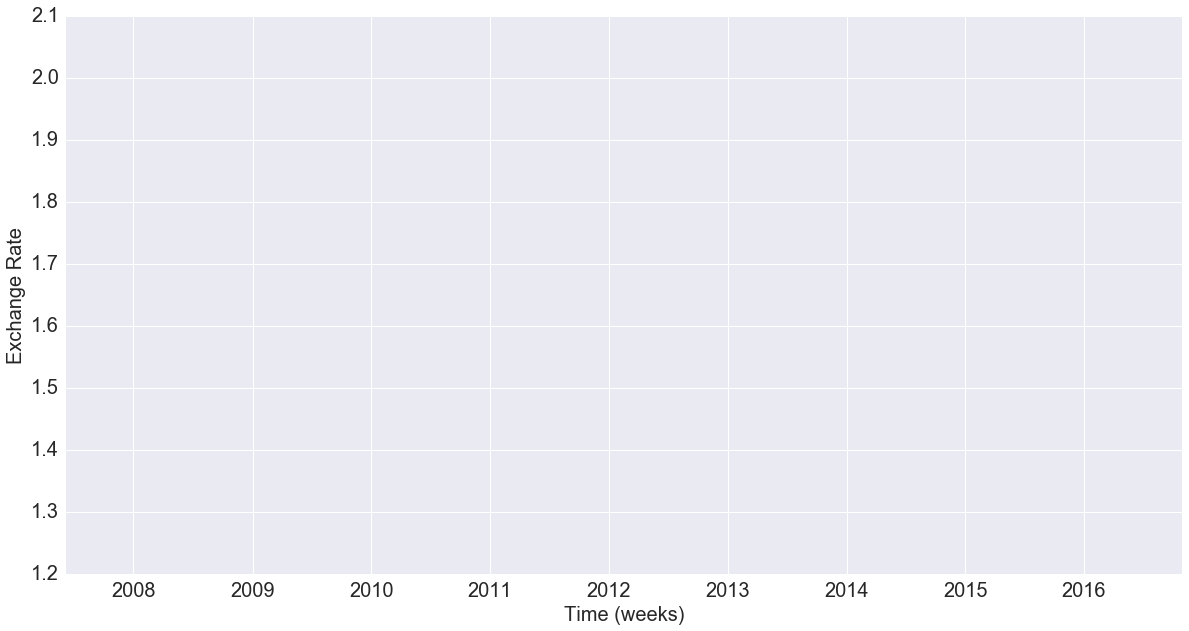

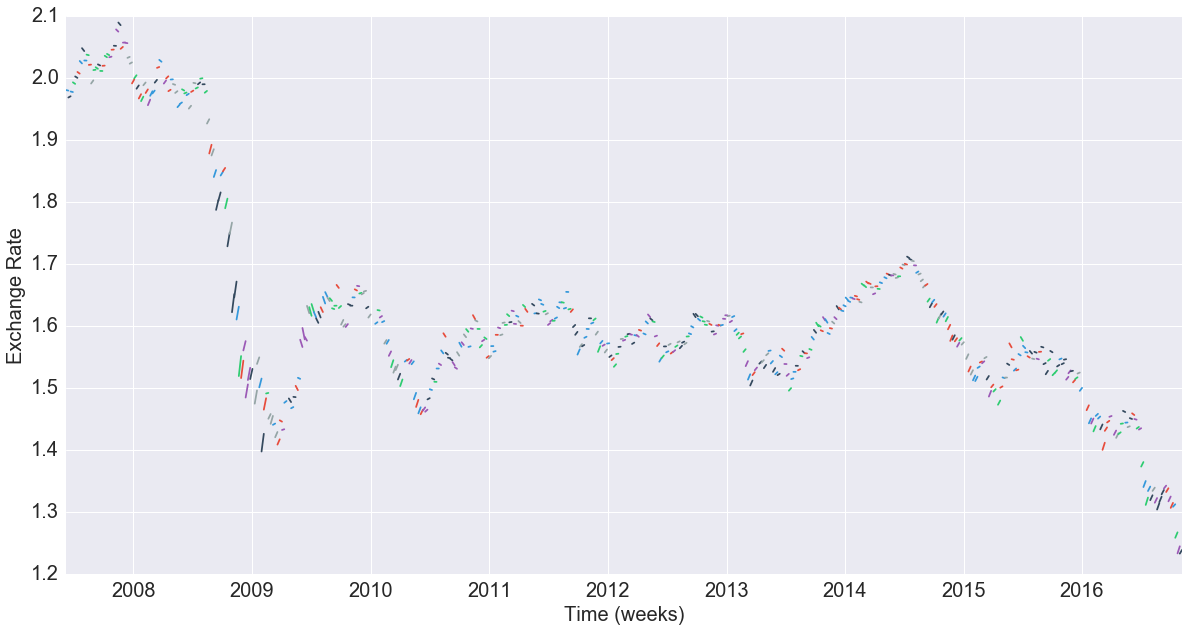

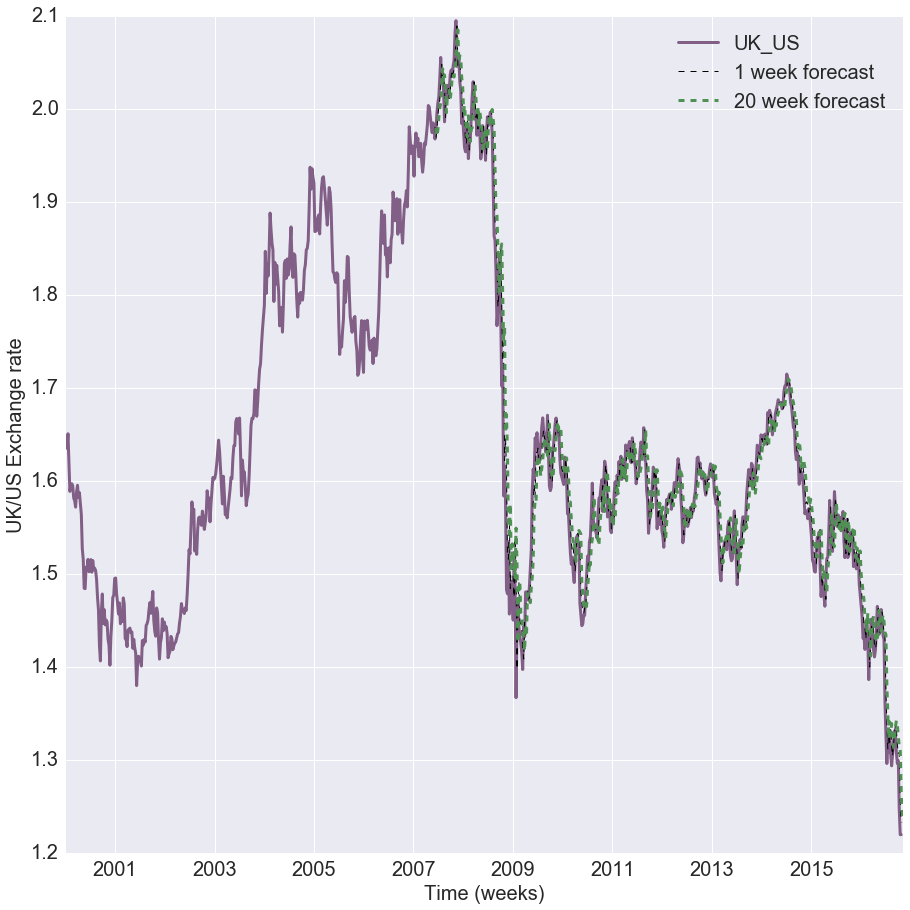

In [86]:
sb.set_palette('muted')
ts_train = ts_filtered['2007':'2016']
ts_predict = ts_filtered['2007':'2016'].values[21:]

# 1 week look ahead forecast
prediction_1_week, prediction_dates_1 = predict_n_weeks(1, ts_train)
r2_1_week = r2_score(ts_predict, prediction_1_week[:-1])
print 'R2 1 week: ', r2_1_week

# # 5 week look ahead forecast
# prediction_5_week, prediction_dates_2 = predict_n_weeks(5, ts_train)

# # 10 week look ahead forecast
# prediction_10_week, prediction_dates_3 = predict_n_weeks(10, ts_train)

# 20 week look ahead forecast
prediction_20_week, prediction_dates_4 = predict_n_weeks(2, ts_train)
r2_20_week = r2_score(ts_predict, prediction_20_week[:-1])
print 'R2 20 week: ', r2_20_week

plt.figure(figsize=(15,15))

# actual values
plt.plot(ts_filtered.index, ts_filtered, linewidth=3, color=sb.xkcd_rgb["dusty purple"])


# 1 week forecast
plt.plot(prediction_dates_1, prediction_1_week, color=sb.xkcd_rgb["black"], linestyle='dashed', label='1 week forecast', linewidth=1)
# plt.plot(prediction_dates_2, prediction_5_week, color='magenta', label='5 week forecast')
# plt.plot(prediction_dates_3, prediction_10_week, color='magenta', label='10 week forecast')
plt.plot(prediction_dates_4, prediction_20_week, color=sb.xkcd_rgb["light forest green"], linestyle='dashed',label='20 week forecast', linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('UK/US Exchange rate', fontsize=20)
plt.xlabel('Time (weeks)', fontsize=20)
plt.legend(fontsize=20)


The coloured plot shows a 20 week forward forecast from each time point. For predictions greater than 2 weeks in the future, the deviation from the actual value increases significantly and the predictions are essentially not very useful. 

## Forecasting 20 weeks from the end of the training data (end of October 2016)

In [80]:
x_train = ts_filtered
x_test = x_train.iloc[-20:].values[::-1]
last_date = x_train.index[-1]
predictions, dates = forecast(lasso_model, 40, x_test, last_date)

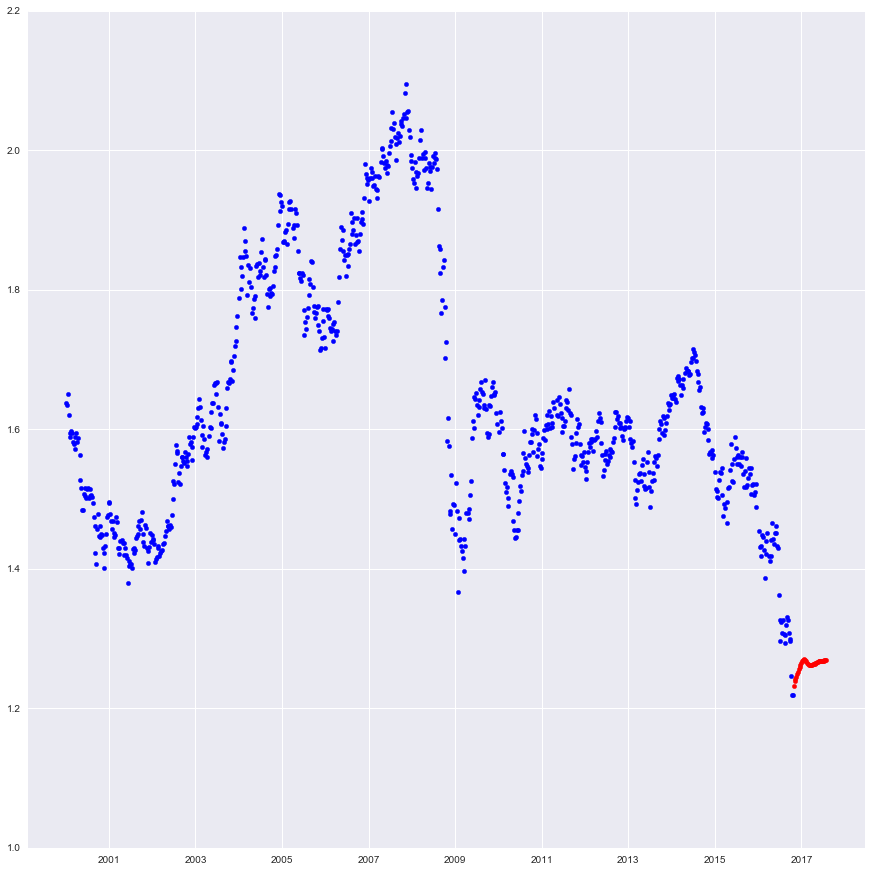

In [81]:
plt.figure(figsize=(15,15))
plt.scatter(dates, predictions, color='red')
plt.scatter(ts_filtered.index, ts_filtered.values, color='blue')

## TODO:  Try different Sentiment Scores 